## Classifying activities with the PAMAP dataset we introduced in Part 1, and use deep learning models

Previously in part2, we used k-fold cross validation with a single participant's data and some simple features, with KNN or svm classifiers to detect the activities. In this Part, we will reuse some of the codes from part2, like loading the original data and balancing the samples. But we will do something different:


1.   First we will do leave-person-out validation instead of k-fold within a single person
2.   Intead of calculating features, we will use a deep neural network that feeds directly on the sensor data. In the previous part2 we needed to first calculate abstract features for every sample window before giving the data to the classifier, because probabilisitc classifiers do not directly work on raw multichannel temporal data.
3.   Because training a neural network is different from fitting a classifier, as classifiers are mathematical representations and the current implementations give you the optimal result. Training a neural network


In [ ]:
#import the packages that we need
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import itertools
from sklearn import neighbors, metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_validate
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Import files from drive
from google.colab import drive
drive.mount('/content/drive')
# this might prompt you to authorize and might take a minute
!cp -r "/content/drive/My Drive/PAMAP2_Dataset/WindowSamples" .

Mounted at /content/drive


In [ ]:
def loadXy(ID):
  # Default file names
  fileName = 'WindowSamples/subject10'+str(ID)+'.npz'
  # Load data from numpy file
  data = np.load(fileName)
  # first lets see what's in the file
  #for k in data.iterkeys():
  #  print(k)
  # Skip the first column because it's timestamp
  X = data['arr_0'][:,:,1:4]
  y = data['arr_1']
  return X, y

def balance_data(X, y):
  X_balanced = np.zeros((0, X.shape[1], X.shape[2])) #note we've changed from X_features to X for simplicity
  y_balanced = np.zeros((0))
  #first let's count how many samples are in each class.
  numClass = len(np.unique(y))
  m_counts = np.zeros((numClass))
  m_labels = np.unique(y)
  for i in range(0, numClass):
    m_counts[i] = int(sum(y==m_labels[i]))
  m_least = int(m_counts.min())
  for i in range(1, numClass): # note we are jumping over class 0 now
    rand_ind = np.random.permutation(int(m_counts[i]))
    m_subind = np.where(y==m_labels[i]) # this is the sub-index of the current class in the whole data file
    m_subind_balanced = m_subind[0][rand_ind[0:m_least]]
    # add the selected samples from the current class to the overall balanced dataset
    X_balanced = np.concatenate( (X_balanced, X[m_subind_balanced,:,:]) )
    y_balanced = np.concatenate( (y_balanced, y[m_subind_balanced]) )
  return X_balanced, y_balanced

def plot_confusion_matrix(cm, class_names):
  """
  You can mostly ignore this function
  Returns a matplotlib figure containing the plotted confusion matrix.
  Args:
  cm (array, shape = [n, n]): a confusion matrix of integer classes
  class_names (array, shape = [n]): String names of the integer classes
  """
  figure = plt.figure(figsize=(len(class_names)/2, len(class_names)/2))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  acc = np.sum( cm * np.eye(len(class_names)) ) / np.sum(cm)

  plt.title("CM , acc:"+str(round(acc,4)))
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  #plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  #plt.show()
  return figure

def label2categorical(m_labels, numClass):
  m_labels_exp = np.zeros( ( len(m_labels), numClass ) )
  LUT = np.unique(m_labels) # to handel sporadically distributed labels
  for i in range (0, len(m_labels)):
      m_labels_exp[i, np.where(LUT==int(m_labels[i]))] = 1
  return m_labels_exp

In [ ]:
X, y = loadXy(1)
X_test, y_test = balance_data(X, y)

print(X_test.shape)
print(y_test.shape)

# Check the activites performed by the subject
print(np.unique(y_test))
numClass = len(np.unique(y_test))

(3048, 200, 3)
(3048,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [ ]:
# then we prepare the training data with persons 2-8
X_train = np.zeros((0,200,3)) # (sample, time, channel)
y_train = np.zeros((0))
for ID in range(2,8):
  print('ID: '+str(ID))
  X, y = loadXy(ID)
  X, y = balance_data(X,y)
  X_train = np.concatenate( (X_train, X) )
  y_train = np.concatenate( (y_train, y) )

print(X_train.shape)
print(y_train.shape)

# Check the activites performed by the subjects
print(np.unique(y_train))
numClass = len(np.unique(y_train))

ID: 2
ID: 3
ID: 4
ID: 5
ID: 6
ID: 7
(9093, 200, 3)
(9093,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [ ]:
def build_CNN(filters = 20, kernel = (3), dense = 20, numClass = 12):
  model = keras.models.Sequential([
        layers.Conv1D( filters = filters, kernel_size = kernel, padding='same', activation='relu', input_shape=(200,3)),
        layers.MaxPooling1D(pool_size=(5)),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv1D( filters = filters, kernel_size = kernel, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=(5)),
        layers.Dropout(0.2),
        layers.Conv1D( filters = filters, kernel_size = kernel, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(dense, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(numClass, activation='softmax')
  ])
  return model



In [ ]:
model = build_CNN()
# optimizer
m_opt = keras.optimizers.Adam()
model.compile(optimizer=m_opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 200, 20)             │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 40, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 40, 20)              │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 40, 20)              │           1,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 40, 20)              │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 8, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 8, 20)               │           1,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 20)               │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           3,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,232 (24.34 KB)

 Non-trainable params: 120 (480.00 B)

In [ ]:
# open loop training code block
epoch = 100
batch = 200
numClass = 12
history = model.fit( x = X_train, y = label2categorical(y_train, numClass), epochs = epoch, batch_size=batch,
              verbose = 2
        )


Epoch 1/100
46/46 - 5s - 115ms/step - accuracy: 0.1221 - loss: 0.5539
Epoch 2/100
46/46 - 2s - 46ms/step - accuracy: 0.2301 - loss: 0.3236
Epoch 3/100
46/46 - 2s - 43ms/step - accuracy: 0.3509 - loss: 0.2587
Epoch 4/100
46/46 - 2s - 39ms/step - accuracy: 0.4354 - loss: 0.2268
Epoch 5/100
46/46 - 1s - 27ms/step - accuracy: 0.4877 - loss: 0.2093
Epoch 6/100
46/46 - 1s - 27ms/step - accuracy: 0.5409 - loss: 0.1929
Epoch 7/100
46/46 - 1s - 28ms/step - accuracy: 0.5707 - loss: 0.1844
Epoch 8/100
46/46 - 2s - 54ms/step - accuracy: 0.5977 - loss: 0.1733
Epoch 9/100
46/46 - 1s - 27ms/step - accuracy: 0.6249 - loss: 0.1655
Epoch 10/100
46/46 - 2s - 40ms/step - accuracy: 0.6496 - loss: 0.1568
Epoch 11/100
46/46 - 3s - 61ms/step - accuracy: 0.6551 - loss: 0.1528
Epoch 12/100
46/46 - 2s - 37ms/step - accuracy: 0.6684 - loss: 0.1476
Epoch 13/100
46/46 - 1s - 27ms/step - accuracy: 0.6834 - loss: 0.1428
Epoch 14/100
46/46 - 1s - 28ms/step - accuracy: 0.7048 - loss: 0.1379
Epoch 15/100
46/46 - 1s - 27

dict_keys(['accuracy', 'loss'])


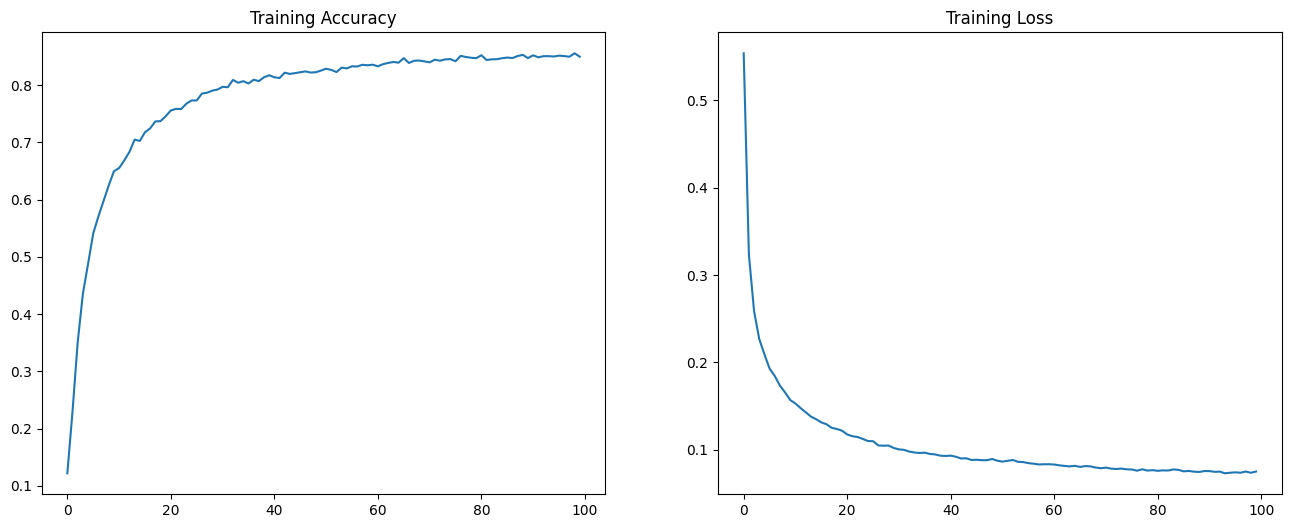

In [ ]:
# history contains the training information about accuracy and loss in every epoch
print(history.history.keys())

figure = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.show()

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
[[126  54   2   0   0   0   0   0   0   0  72   0]
 [ 40  35  69   0   0   0   0   0   0   1 109   0]
 [  0  28 152   0   0   0   0   0   0   0  74   0]
 [  0   1   1 222   0   0   0   9   0   0  21   0]
 [  0   1   0   0 241   0   0   1   0   0  11   0]
 [  0   0   0   0   0 240   0   0   0   0  14   0]
 [  0   3   0   0   0   0 224   0   5   0  21   1]
 [  0   5   2  34   0   0   0 194   0   0  19   0]
 [  0  11   2  12   0   0   0 117  90   0  22   0]
 [  0   1   3   0   0   3   2   0   0 228  17   0]
 [  0   4   0   0   0   0   0   0   2   7 241   0]
 [  0   0   0   3  74   0   3   0  81   4  26  63]]


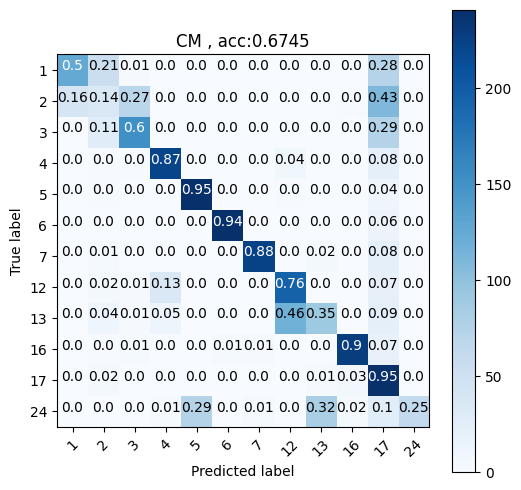

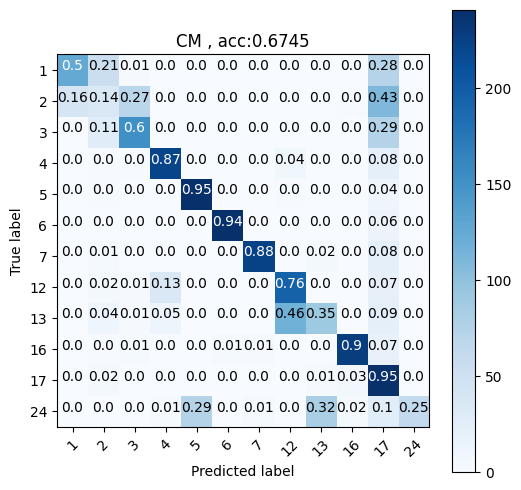

In [ ]:
y_predict = model.predict(X_test)
acc_test = sum(y_test == np.argmax(y_predict, axis=1)) / y_test.shape[0]
y_test_cat = label2categorical(y_test,numClass)
# Convert back from categorical to numerical with np.argmax()
cm = skl.metrics.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_predict, axis=1))
print(cm)
plot_confusion_matrix(cm, np.unique(y_test).astype('int'))

Note this is not expected to be highly accurate because we are doing leave-person-out, so the model is being tested on a complete stranger to generate the confusion matrix.

But, we have no means of knowing when to stop training. So we use the 'validation' process that can be included in the model.fit(). However, when choosing our validation dataset, one should be careful not to use the testing data for validation, as that will be overfitting the training process for the testing data.

We have person 1 as test, person 2-8 as training. We can use a random split among the training data to separate training and validation data.


In [ ]:
X_fit = X_train
y_fit = y_train
X_train, X_valid, y_train, y_valid = train_test_split(X_fit, y_fit, test_size=0.1, shuffle = True)

print(y_train.shape)
print(y_valid.shape)
# make sure no classes are left out in the validation data
print(np.unique(y_train))
print(np.unique(y_valid))

(8183,)
(910,)
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]
[ 1.  2.  3.  4.  5.  6.  7. 12. 13. 16. 17. 24.]


In [ ]:
# closed loop training with validation data and early stopping
#first lest build a clean sheet model
model = build_CNN()
# optimizer
m_opt = keras.optimizers.Adam()
model.compile(optimizer=m_opt,
                      loss=keras.losses.BinaryCrossentropy(),
                      metrics=['accuracy'])
model.summary()

epoch = 5000 # Here, we can afford to have more epochs, because the process will be stoped by the early stopping mechanism
batch = 200
patience = 100 # we wait for 100 epochs after the monitor value does not improve and then stop the process
modelfile = 'model.weights.h5'
cb_checkpoint = keras.callbacks.ModelCheckpoint(modelfile, monitor='val_accuracy', mode='max',
                                                    verbose=1, save_weights_only=True, save_best_only=True)
cb_earlystop = keras.callbacks.EarlyStopping(patience=patience, monitor='val_accuracy', verbose = 1, restore_best_weights=True )
history = model.fit( x = X_train, y = label2categorical(y_train, numClass), epochs = epoch, batch_size=batch,
          #use_multiprocessing = True,
          validation_data = (X_valid, label2categorical(y_valid, numClass)),
          callbacks=[cb_checkpoint, cb_earlystop],
          verbose = 2)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_15 (Conv1D)                   │ (None, 200, 20)             │             200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 40, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 40, 20)              │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 40, 20)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_16 (Conv1D)                   │ (None, 40, 20)              │           1,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 40, 20)              │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 8, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 8, 20)               │           1,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 8, 20)               │              80 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 8, 20)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │           3,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 12)                  │             252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,352 (24.81 KB)

 Trainable params: 6,232 (24.34 KB)

 Non-trainable params: 120 (480.00 B)

Epoch 1/5000

Epoch 1: val_accuracy improved from -inf to 0.15714, saving model to model.weights.h5
41/41 - 5s - 121ms/step - accuracy: 0.1227 - loss: 0.7643 - val_accuracy: 0.1571 - val_loss: 0.5981
Epoch 2/5000

Epoch 2: val_accuracy improved from 0.15714 to 0.21648, saving model to model.weights.h5
41/41 - 2s - 55ms/step - accuracy: 0.1495 - loss: 0.5231 - val_accuracy: 0.2165 - val_loss: 0.4232
Epoch 3/5000

Epoch 3: val_accuracy improved from 0.21648 to 0.28132, saving model to model.weights.h5
41/41 - 1s - 31ms/step - accuracy: 0.1782 - loss: 0.3859 - val_accuracy: 0.2813 - val_loss: 0.2940
Epoch 4/5000

Epoch 4: val_accuracy improved from 0.28132 to 0.39121, saving model to model.weights.h5
41/41 - 1s - 32ms/step - accuracy: 0.2262 - loss: 0.3173 - val_accuracy: 0.3912 - val_loss: 0.2389
Epoch 5/5000

Epoch 5: val_accuracy improved from 0.39121 to 0.51758, saving model to model.weights.h5
41/41 - 3s - 74ms/step - accuracy: 0.2852 - loss: 0.2791 - val_accuracy: 0.5176 - val_loss:

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


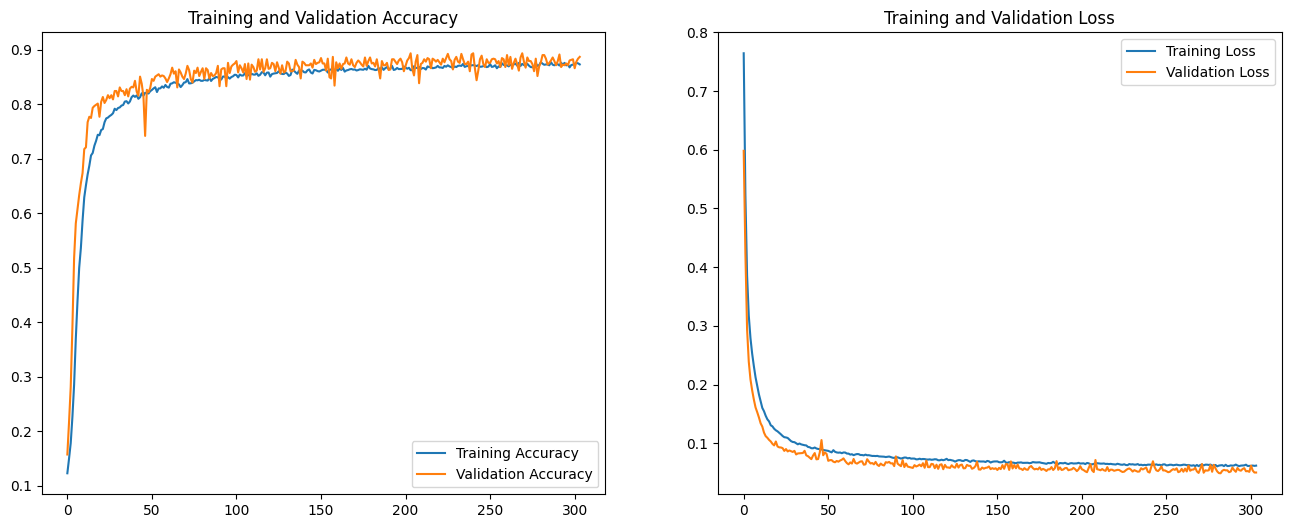

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[128  32   1   0   0   0   0   0   0   1  48  44]
 [ 96  32  73   0   0   0   0   1   0   1  51   0]
 [  0  48 153   0   0   0   0   2   0   2  49   0]
 [  0   4   0 218   0   0   0   8   6   0  18   0]
 [  0   2   0   0 241   0   0   1   1   0   9   0]
 [  0   0   0   0   0 237   0   0   0   0  17   0]
 [  0   3   0   1   1   0 213   0  11   5  20   0]
 [  0   7   0  13   0   0   0 212   5   0  17   0]
 [  0  15   1   0   0   0   0  66 154   0  18   0]
 [  0   0   2   0   0   9   0   0   1 225  17   0]
 [  0   6   0   0   0   0   0   0   0   6 242   0]
 [  0   0   0   0  94   0   0   1  35  11  27  86]]


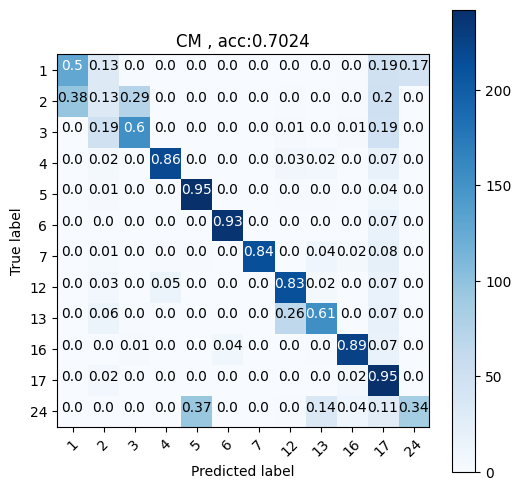

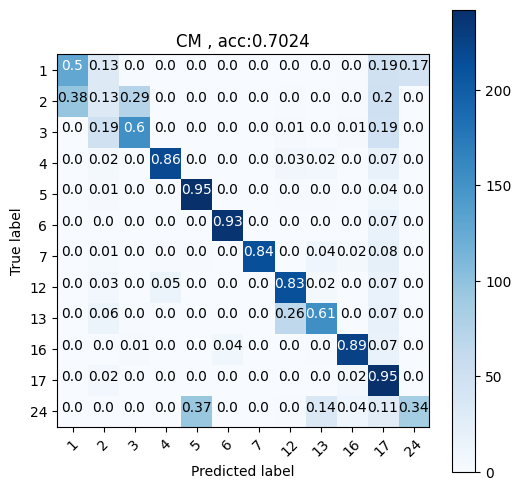

In [ ]:
print(history.history.keys())
figure = plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_predict = model.predict(X_test)
acc_test = sum(y_test == np.argmax(y_predict, axis=1)) / y_test.shape[0]
y_test_cat = label2categorical(y_test,numClass)
cm = skl.metrics.confusion_matrix(np.argmax(y_test_cat, axis=1), np.argmax(y_predict, axis=1))
print(cm)
plot_confusion_matrix(cm, np.unique(y_test).astype('int'))


# Progress So far...

In this part we've seen how to classify activities from multi-channel temporal sensor data with (not so) deep neural networks.

The confusion matrix is not directly comparable with part2, because in part2 we did cross-validation with only one person's data, but here we have proper leave-person-out.
